# Udacity Machine Learning Engineer Nanodegree

- _Project from the Kaggle competition: [Jigsaw unintended bias in toxicity classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview)_
- _Field: Natural Language Processing_<br/>


# Definition

## Project Overview

<span class="rubric done">Student provides a high-level overview of the project in layman's terms. Background information such as the problem domain, the project origin, and related data sets or input data is given.</span>

Natural Language Processing is a complex field which is hypothesised to be part of AI-complete set of problems, implying that the difficulty of these computational problems is equivalent to that of solving the central artificial intelligence problem making computers as intelligent as people. <cite data-cite="AiComplete"></cite>
With over 90% of data ever generated being produced in the last 2 years <cite data-cite="ScienceDaily1"></cite> and with a great proportion being human generated unstructured text there is an ever increasing need to advance the field of Natural Language Processing.

Recent UK Government proposal to have measures to regulate social media companies over harmful content, including "substantial" fines and the ability to block services that do not stick to the rules is an example of the regulamentory need to better manage the content that is being generated by users. <cite data-cite="BBCSocialMedia"></cite> 

Other initiatives like [Riot Games](https://www.riotgames.com/en)'s work aimed to predict and reform toxic player behaviour during games <cite data-cite="ArsRiotGame"></cite> is another example of this effort to understand the content being generated by users and moderate toxic content.

However, as highlighted by the Kaggle competition [Jigsaw unintended bias in toxicity classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview), existing models suffer from unintended bias where models might predict high likelihood of toxicity for content containing certain words (e.g. "gay") even when those comments were not actually toxic (such as "I am a gay woman"), leaving  machine only classification models still sub-standard.

Having tools that are able to flag up toxic content without suffering from unintended bias is of paramount importance to preserve Internet's fairness and freedom of speech.


## Problem Statement

<span class="rubric">The problem which needs to be solved is clearly defined. <span class="warn">A strategy for solving the problem, including discussion of the expected solution, has been made.</span></span>

From [Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview) competition page:

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Last year, in the Toxic Comment Classification Challenge, participants built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations.

Here's the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.


## Metrics

<span class="done rubric">Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.<span>

This competition uses a newly developed metric that combines several submetrics to balance overall performance with various aspects of unintended bias.

Please refer to [evaluation section](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation) of the competition and the provided [benchmark kernel](https://www.kaggle.com/dborkan/benchmark-kernel) with code to calculate the competition evaluation metrics.

Here are defined the submetrics:

### Overall AUC
This is the ROC-AUC for the full evaluation set.


### Bias AUCs

To measure unintended bias, we again calculate the ROC-AUC, this time on three specific subsets of the test set for each identity, each capturing a different aspect of unintended bias. You can learn more about these metrics in Conversation AI's recent paper *[Nuanced Metrics for Measuring Unintended Bias with Real Data in Text Classification](https://arxiv.org/abs/1903.04561)*. <cite data-cite="1903.04561"></cite>

**Subgroup AUC:** Here, we restrict the data set to only the examples that mention the specific identity subgroup. *A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity*.

**BPSN (Background Positive, Subgroup Negative) AUC:** Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. *A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not*, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

**BNSP (Background Negative, Subgroup Positive) AUC:** Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. *A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not*, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.

### Generalized Mean of Bias AUCs

To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:


$M_p(m_s)=( \frac{1}{N} \sum_{s=1}^{N}m_{s}^{p} )^{\frac{1}{p}}$

where:

MpMp = the ppth power-mean function\
msms = the bias metric mm calulated for subgroup ss\
NN = number of identity subgroups

For this competition, we use a pp value of -5 to encourage competitors to improve the model for the identity subgroups with the lowest model performance.

### Final Metric

We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

$score=w_0AUC_{overall}+\sum_{a=1}^{A}w_aM_p(m_{s,a})$

where:

- $A$ = number of submetrics (3)
- $ms_{s,a}$ = bias metric for identity subgroup ss using submetric $a$
$w_a$ = a weighting for the relative importance of each submetric; all four $w$ values set to 0.25

While the leaderboard will be determined by this single number, we highly recommend looking at the individual submetric results, [as shown in this kernel](https://www.kaggle.com/dborkan/benchmark-kernel), to guide you as you develop your models.

# Analysis

## Data Exploration

<span class="rubric">If a dataset is present, features and calculated statistics relevant to the problem have been reported and discussed, along with a sampling of the data. In lieu of a dataset, a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.<span>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

train_path = './input/jigsaw-unintended-bias-in-toxicity-classification/train.csv'
test_path = './input/jigsaw-unintended-bias-in-toxicity-classification/test.csv'

It is important to create a reproducible analysis, operation like sampling are inherently stochastic and as such vary. `Reproducibility` class handles seeding to make the analysis reproducible.

In [2]:
# Making sure that analysis is reproducible
from notebooks.library.Reproducibility \
    import *

Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()

In [3]:
# Loading train and test data
from notebooks.library.ExploratoryAnalysis \
    import ExploratoryAnalysis, JigsawExploratoryAnalysis

explore = JigsawExploratoryAnalysis(train_path = train_path, test_path= test_path)

### Train and test stats

Below are some of the train and test datasets statistics.

We have a little short of 2 million comments in our training set and short of 100 thousands comments in the test set, that is 5.4% of the training data.

Further more 5.9% of comments in the training set are considered _toxic_.

Here a _toxic_ comment is considered a comment whose toxicity score is greater than 0.5 in a range between 0-1

In [4]:
test_percent, toxic_comment_distribution = explore.calculate_stats()

print("The train set contains {} number of samples"\
      .format(len(explore.train)))
print("The test set contains {} number of samples"\
      .format(len(explore.test)))
print("The test set is {0:.1f}% of the training set"\
      .format(test_percent * 100))
print("The test set contains {} toxic comment"\
      .format(explore.train['toxic'].sum().sum()))
print("Toxic comments are {0:.1f}% of the total comments"\
      .format(toxic_comment_distribution * 100))

The train set contains 1804874 number of samples
The test set contains 97320 number of samples
The test set is 5.4% of the training set
The test set contains 106438 toxic comment
Toxic comments are 5.9% of the total comments


### Toxicity score distribution

Since the toxicity score is a continuous variable within the range 0-1, it is interesting to observe the distribution of the score among the training set.

We can see that highly toxic score are quite rare, and most of the comments that have been given a toxicity greater than 0 still lie below the 0.5 threshold.

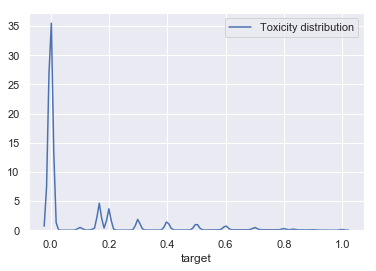

In [5]:
sns.distplot(explore.train['target'], \
             hist=False, kde=True, label="Toxicity distribution")

![](images/toxicity-distribution.png)

### Distribution of toxic/non-toxic in the training set divided per identity


We are interested to improve the toxicity classification within each identity group, as some group carry some unintended bias.

We can see below some stats regarding:

- the number of comments (`count`) within each group (`indentity`) 
- the number of toxic comment (`toxic_count`) within each group
- the percentage of toxic_comment within each group (`toxic_percent`)
- the number of null values (`na_count`) contained within each group


In [13]:
toxic_stats = explore.calculate_toxic_stats_for_identities(threshold=0.5)    
toxic_stats.sort_values(['toxic_percent', 'count'], axis=0, ascending=False)


,identity,toxic_count,count,toxic_percent,na_count
6,black,3079,13869,0.222006,0
2,homosexual_gay_or_lesbian,2005,10233,0.195935,0
7,white,4660,23852,0.195371,0
8,psychiatric_or_mental_illness,628,4077,0.154035,0
5,muslim,2974,19666,0.151225,0
4,jewish,763,7239,0.105401,0
0,male,4187,40036,0.104581,0
1,female,4689,50548,0.092763,0
3,christian,2099,35507,0.059115,0


The table above is sorted by the percentage of toxic comments then by the overall number of documents within the identity group.

From above that the identity group `black` has the highest number of toxic comments, closely followed by `homosexual_gay_or_lesbian` and `white`.

By plotting the distribution of percent-of-toxic-comment-per-group we can see that it follows a normal distribution and that the identity `black` is above 1 standard deviation from the mean, while `christian` is below 1 standard deviation. 

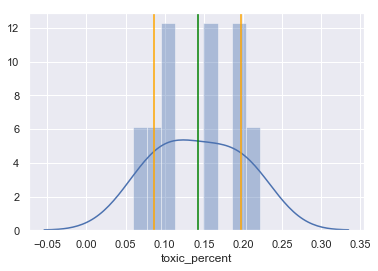

In [30]:
t_percent = toxic_stats['toxic_percent']
sns.distplot(t_percent, bins = 9)
plt.axvline(t_percent.mean(), 0,12, color = 'green')
plt.axvline(t_percent.mean() - t_percent.std(), 0,12, color= 'orange')
plt.axvline(t_percent.mean() + t_percent.std(), 0,12, color= 'orange')

In [31]:
no_identity_train, identity_train = explore.calculate_no_identity_stats()

In [32]:
no_identity_toxic_count = len(no_identity_train[(no_identity_train['toxic'] > 0)])
no_identity_count = len(no_identity_train)
no_identity_toxic_percent = no_identity_toxic_count / no_identity_count
identity_count = len(identity_train)
assert(identity_count  + no_identity_count == len(explore.train))

### Statistics of samples having no identity been set

From the statistics printed below it can be seen that only 11.65% of the training samples have been labelled with an identity.

In [34]:
print("The number of samples with no identity is {}"\
      .format(no_identity_count))
print("The number of samples with no identity that are toxic is {}"\
      .format(no_identity_toxic_count))
print("The percentage of samples with no identity that are toxic is {0:.2f}% "\
      .format(no_identity_toxic_percent * 100))
print("The number of samples with one or more identities being set is {}"\
      .format(identity_count))
print("The percentage of samples with one or more identities being set is {0:.2f}%"\
      .format(identity_count/len(explore.train) * 100))


The number of samples with no identity is 1594682
The number of samples with no identity that are toxic is 84154
The percentage of samples with no identity that are toxic is 5.28% 
The number of samples with one or more identities being set is 210192
The percentage of samples with one or more identities being set is 11.65%


### Distribution of toxic /non-toxic comments in subgroups

We can see below some statistics regarding toxic/non-toxic comments in each subgroup:

- the number of comments (`count`) within each (`subgroup`) 
- the number of toxic comment (`toxic_count`) within each subgroup
- the percentage of toxic_comment within each subgroup (`toxic_percent`)
- the number of null values (`na_count`) contained within each subgroup

In [149]:
toxic_subgroup_stats = explore.calculate_toxic_stats_for_subgroups(0.5)
toxic_subgroup_stats

,subgroup,toxic_count,count,toxic_percent,na_count
0,severe_toxicity,8,8,1.000000,0
1,obscene,7494,7648,0.979864,0
2,threat,2707,2793,0.969209,0
3,insult,78125,79887,0.977944,0
4,identity_attack,7094,7633,0.929386,0
5,sexual_explicit,2762,3119,0.885540,0


### Is there a correlation between identities

The plot below shows that there is no evidence of correlation between the different identities identities

In [ ]:
sns.pairplot(explore.train[JigsawExploratoryAnalysis.identity_columns].sample(10000))

![](images/identity-correlation-plot.png)

### Exploring some toxic comments with special characters

It is common in NLP to remove from the corpus punctuations, very common words and special characters as generally those don't contribute to the overall meaning of the sentence.

However in some toxic comments, special characters are used to camouflage swear or offensive words to circumvent the filtering mechanism that are in place on most social platforms.

Below are some of those camouflaged words.

In [138]:
special_char_toxic = explore.train[\
                                   (explore.train.comment_text.str.contains(r'\w{0,}[\%\@\&$\#\*]{2,}\w{0,}')) \
                                   & (explore.train.toxic == 1)]

In [139]:
import re
camouflage_regex = re.compile(r'\w{0,}[\%\@\&$\#\*]{2,}\w{0,}')                              
camouflaged_words = [camouflage_regex.search(comm).group(0) for comm in special_char_toxic.comment_text]

In [143]:
random.sample(camouflaged_words, 7)

['dumba**', 'bi**h', 'f******edge', '**back', '***', 'f***', 'a**hole']

### Comments lengths

Below it is plotted the distribution of the `comment_text` length across a sample of 10000 message. 
This statistic is useful for choosing the maximum comment length to which we will be cropping the text before using it in the training.

From the distribution below we see that the majority of comments are less than 100 words long, however there is still a significant number of comments that have between 100 and 200 words.

In [7]:
from notebooks.library.ObsceneTextPreprocessor \
    import ObsceneTextPreprocessor

processor = ObsceneTextPreprocessor()

In [84]:
sample = explore.train['comment_text'].sample(10000)
document_lengths = [len(processor.clean_doc(doc)) for doc in sample]
percentiles = np.percentile(document_lengths, [25, 50, 75, 95, 100])

In [83]:
print("95% of comments are {0:.0f} words or less".format(percentiles[3]))

95% of comments are 163 words or less


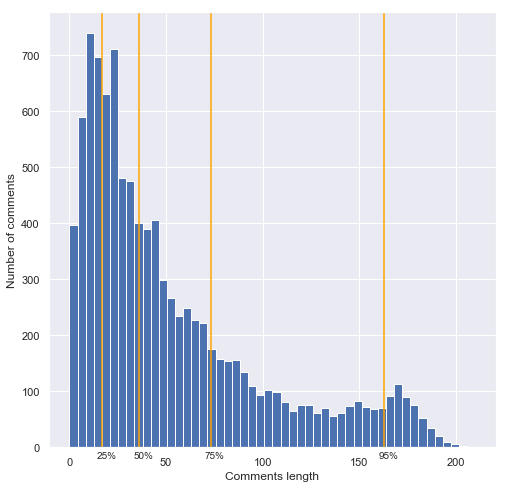

In [70]:

fig = plt.figure(figsize=(8, 8)) 
plt.xlabel('Comments length')
plt.ylabel('Number of comments')
plt.hist(document_lengths, bins=50)
plt.axvline(percentiles[0], 0,700, color = 'orange')
plt.annotate('25%', xy=(percentiles[0], 700), xytext=(percentiles[0]-3, -20))
plt.axvline(percentiles[1], 0,700, color = 'orange')
plt.annotate('50%', xy=(percentiles[1], 700), xytext=(percentiles[1]-3, -20))
plt.axvline(percentiles[2], 0,700, color = 'orange')
plt.annotate('75%', xy=(percentiles[2], 700), xytext=(percentiles[2]-3, -20))
plt.axvline(percentiles[3], 0,700, color = 'orange')
plt.annotate('95%', xy=(percentiles[3], 700), xytext=(percentiles[3]-3, -20))

plt.show()

In [23]:
np.percentile(document_lengths, [25, 50, 75])

array([17., 36., 74.])

### Dictionary exploration

Below are statistics regarding the number of words in the cleaned corpus and the size of the derived dictionary.

In [9]:
clean_comments = processor.clean(explore.train['comment_text'])

In [11]:
from notebooks.library.TextTokenizer \
    import TextTokenizer

Using TensorFlow backend.


In [12]:
tokenizer = TextTokenizer(clean_comments, [])

In [14]:
(_, all_words_count, unique_words_count) = tokenizer.get_stats()

print('There are are a total of {} words in the cleaned corpus.'.format(all_words_count))
print('The dictionary contains {} words.'.format(unique_words_count))

There are are a total of 95503548 words in the cleaned corpus.
The dictionary contains 460165 words.


## Algorithms and Techniques

<span class="rubric"> Algorithms and techniques used in the project are thoroughly discussed and properly justified based on the characteristics of the problem.</span>

### Toxicity classification with LSTM

Sequence models like RNN have transformed speech recognition, DNA sequencing and natural language processing and other areas where the input is a sequence of various length and where different elements of the sequence share common features.

RNNs therefore are particularly suited to model the natural language, they are able to pass to subsequent steps features captured in previous steps.

However, basic RNNs will have problems _remembering_ features learned several time steps earlier.


#### Long Short-Term Memory

A special form of RNN is the Long Short-Term Memory (LSTM) architecture  <span class="warn">paper link</span>. 

LSTM are able to _remember_ also features extracted several time steps before by containing a series of _'Gates'_ in control of what to remember and what to forget from previous time steps.

Furthermore, they overcome two common problems of basic RNN architectures, [vanishing and 
exploding gradients problems](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

##### LSTM architecture

Let's suppose we have the following sequence as input $x$ = "the fox jumped over the lazy dog"

In the above sentence, $x^{<1>}$ represents the word _'the'_, $x^{<2>}$ represents the word _'fox'_, $x^{<3>}$ represent the word _'jumped'_, $x^{<7>}$ represents _'dog'_ etc. More generally $x^{<t>}$ represent a word in a sequence at time step $t$.

An LSTM unit, at time step _t_ takes 3 key inputs:

- $x^{<t>}$ - the segment at time step _t_
- $c^{<t-1>}$ - the cell memory at time step _(t - 1)_
- $a^{<t-1>}$ - the cell activation at time step _(t - 1)_

The LSTM unit calculates:

- $\tilde{c}^{<t>} = \tanh(W_c[a^{<t-1>}, x^{<t>}] + b_c)$ - a new memory state candidate at time step _t_
- $\Gamma_u = \sigma(W_u[a^{<t-1>}, x^{<t>}] + b_u)$ - the update gate, it determines how much of the new memory state candidate should be used
- $\Gamma_f = \sigma(W_f[a^{<t-1>}, x^{<t>}] + b_f)$ - the forget gate, it determines how much of the received memory state should be retained
- $\Gamma_o = \sigma(W_o[a^{<t-1>}, x^{<t>}] + b_o)$ - the output gate, it calculates the activation output
- $c^{<t>} = \Gamma_u * \tilde{c}^{<t>} + \Gamma_f * c^{<t-1>}$ - it calculates how much of $\tilde{c}^{<t>}$ and $c^{<t-1>}$ will be retained in the new memory state
- $a^{<t>} = \Gamma_o * \tanh({c}^{<t>})$ - it calculates the activation at time step _t_
- $y^{<t>} = softmax(a^{<t>})$ - the prediction y

The LSTM unit outputs the followings, those will be the input of the the LSTM unit at time step _(t + 1)_:
- $c^{<t>}$
- $a^{<t>}$
- $y^{<t>}$

In this architecture, the state (memory) of previous time steps is propagated to further steps, the update and forget gates determine how much of the received state is retained and how much of newly created state is added to the memory. 

A variation to this architecture are bidirectional LSTMs, these calculate their prediction not only based on previous time steps but also based on subsequent time steps. This feature  is particularly useful when subsequent elements of a sequence contribute in determining the features of the element at time step _t_.  

##### Use of LSTM for the Jigsaw problem

LSTM are very powerful in creating a language models that can learn the relationship between words, how a sequence of words can give a completely different meaning to a word if the same word were taken in isolation. 

LSTMs are therefore particularly suited in identifying toxic comments not based on the presence/absence of individual words but rather on how these words act together to convey their meaning.

### Reproducibility and choice of library

In Data Science, it is important to being able to turn stochastic processes into deterministic ones in order to being able to allow peers to review findings and conclusions.

However also when benchmarking an Machine Learning algorithm it is often very useful to being able to reproduce the same results so to measure scores that are consistent across different runs. 

An alternative would be running the same experiment multiple times, sampling the results and averaging them which is a painstaking process and very time consuming.

I have 

```
Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()
```

### Text cleaning and tokenisation



### Embeddings creation, use of FastText
### Data sampling
### Memory clearing
### Long Short Term Memory LSTM
### Object oriented approach
### Collating all modules into a single file and submission





```
Epoch 1/10 	 loss=0.1107 	 time=215.25s
Epoch 2/10 	 loss=0.0964 	 time=214.80s
Epoch 3/10 	 loss=0.0919 	 time=217.40s
Epoch 4/10 	 loss=0.0892 	 time=214.78s
Epoch 5/10 	 loss=0.0873 	 time=216.08s
Epoch 6/10 	 loss=0.0860 	 time=215.63s
Epoch 7/10 	 loss=0.0852 	 time=217.54s
Epoch 8/10 	 loss=0.0846 	 time=215.30s
Epoch 9/10 	 loss=0.0844 	 time=216.95s
Epoch 10/10 	loss=0.0841 	 time=216.06s


```

### Comparison between model losses

From the plot below ...<span class="warn"> continue </span>

#### Model 1, settings 1

- 10 Epochs
- 100 words text

#### Model 1, settings 2

- 10 Epochs
- 220 word text

#### Model 1, settings 3

- 10 Epochs
- 130 word text


#### Model 1, settings 4

- 20 Epochs
- 130 word text

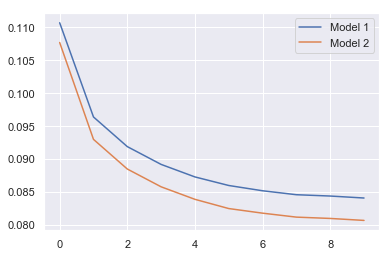

In [16]:


model1_loss = [0.1107, 0.0964, 0.0919, 0.0892, 0.0873, 0.0860, 0.0852, 0.0846, 0.0844, 0.0841]
model2_loss = [0.1077, 0.0930, 0.0885, 0.0858, 0.0839, 0.0825, 0.0818, 0.0812, 0.0810, 0.0807]


plt.plot(model1_loss, label='Model 1')
plt.plot(model2_loss, label='Model 2')
plt.legend(loc='upper right')
plt.show()

## Benchmark

<span class="rubric done">
Student clearly defines a benchmark result or threshold for comparing performances of solutions obtained.
</span>

As any other Kaggle competition, submissions are benchmarked against the test set held by Jigsaw producing a score as per the _Evaluation metrics_ defined below.

Submissions to this competition must be made through Kernels, also the following conditions must be met:

-   CPU Kernel <= 9 hours run-time
-   GPU Kernel <= 2 hours run-time
-   No internet access enabled
-   External data, freely & publicly available, is allowed, including pre-trained models
-   No custom packages enabled in kernels
-   Submission file must be named "submission.csv"


The [Kaggle Completition Leaderboard](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/leaderboard) provides 3 benchmark kernels against which I'm measuring my score.

- **Benchmark Kernel** with a score of 0.88224
- **TOXICITY@1 Benchmark** with a score of 0.89082
- **TOXICITY@6 Benchmark** with a score of 0.89219




# Methodology


## Data Preprocessing

<span class="rubric">
    All preprocessing steps have been clearly documented. Abnormalities or characteristics about the data or input that needed to be addressed have been corrected. If no data preprocessing is necessary, it has been clearly justified.
</span>

### Obscene Text Preprocessor

As discussed earlier on in the _Data exploration_ section, it is common in NLP to remove from the corpus punctuations, very common words and special characters as generally those don't contribute to the overall meaning of the sentence. However when dealing with toxic comments, special characters are used to camouflage swear or offensive words to circumvent the filtering mechanism that are in place on most social platforms.

The `ObsceneTextProcessor` class tries to identify those words that are using punctuation to camouflage offensive words and replaces it with a sample swear word that is present in the `embeddings` dictionary.

Also, from exploration of comments that are highly toxic, it seems they tend to be very 'opinionated' about other individuals while generally bragging about oneself. I have therefore decided to leave these [personal pronouns](https://en.wikipedia.org/wiki/Personal_pronoun) which, are generally removed during tokenisation because are considered [stop words](https://en.wikipedia.org/wiki/Stop_words)


### Tokenisation

One of the very first steps in building a language model is tokenisation, that is transforming a corpus of text into a dictionary of its components words, generally referred to as tokens.

Once a dictionary is built, we can represents each word that is encountered in numerical terms. There are two main approaches to represent a word, a _one-hot-encoding_ approach turns a word into a binary vector of the length of the dictionary where it contains all zeros except for a one at the index position of the word in the dictionary, this works well with a small dictionaries. 

A second approach is to represent a word by its index in the dictionary, this turns a sentence into a vector of dictionary indices making word representation much more memory efficient.

Because we are dealing with a large corpus of over 95 million words and a dictionary of nearly half a million words, _one-hot-encoding_ is not appropriate here.

#### Padding sentences

When representing sentences as a sequence of indices, it is common to standardise the length of the samples by means of adding padding to shorter sentences or clipping longer sentences.

In the choice of padding I have used the statistics gathered in the exploratory analysis phase, this shows that the  distribution of sentences lengths, 95% of comments are 163 words or less and 99% of sentences are less than 200 words. Having benchmarked the predictions on various clipping lengths, I have chosen to capture 99% of words setting the clipping/padding to 200 words. 


### Embeddings using FastText

A further step into build a language model is to create words embeddings. An embedding is a vector representation of a word which capture some of the semantic of a word. There are different pre-trained embedding libraries like **Word2Vec**, **GloVe** and **FastText**.

Word2Vec and GloVe were trained on completed words found in their training corpus, misspelled words or rare words that were not found in their training corpus won't have a vector assigned.

On the other hand FastText breaks words into several n-grams of sub-words. For instance, the tri-grams for the word apple is app, ppl, and ple. Rare words can now be properly represented since it is highly likely that some of their n-grams also appears in other words. <cite data-cite="SentimentAnalysis.Medium"></cite>


## Implementation

<span class="rubric">
The process for which metrics, algorithms, and techniques were implemented with the given datasets or input data has been thoroughly documented. Complications that occurred during the coding process are discussed.
</span>


### Reproducibility

Due to the stochastic nature of Neural Networks it is not always possible to reproduce the same results over different runs. However in order to evaluate different algorithms implementations it is important to being able to have stable and reproducible results.

<span class="warn">
Keras's implementation of Neural Networks mantain its stochastic nature.

https://pytorch.org/docs/stable/notes/randomness.html

</span>

```
Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()
```
## Refinement

<span class="rubric">
The process of improving upon the algorithms and techniques used is clearly documented. Both the initial and final solutions are reported, along with intermediate solutions, if necessary.
</span>

# Results

## Model Evaluation and Validation

<span class="rubric">
The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.
</span>

## Justification

<span class="rubric">
The final results are compared to the benchmark result or threshold with some type of statistical analysis. Justification is made as to whether the final model and solution is significant enough to have adequately solved the problem.
</span>

# Conclusion

## Free-Form Visualization

<span class="rubric">
A visualization has been provided that emphasizes an important quality about the project with thorough discussion. Visual cues are clearly defined.
</span>

## Reflection

<span class="rubric">
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.
</span>

## Improvement

<span class="rubric">
Discussion is made as to how one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.
</span>

# Quality

## Presentation

<span class="rubric">
Project report follows a well-organized structure and would be readily understood by its intended audience. Each section is written in a clear, concise and specific manner. Few grammatical and spelling mistakes are present. All resources used to complete the project are cited and referenced.
</span>

In [44]:
%%html

<style>
    .warn {
        color: red;
    }
    .rubric {
        color: gray;
        border: 1px dashed gray;
        padding: 5px 4px;
        display: table;
        margin-top: 10px;        
    }
    .rubric.done {
        color: #e3eaa7;
    }
</style>